## Self Distillation test

In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path.

import branching

from branching import branches
from branching import evaluate

# branching.enable_neptune(False)


In [2]:
train_ds, test_ds, validation_ds = branching.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [3]:
train_ds100, test_ds100, validation_ds100 = branching.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


### Define the Branch Model. this is a subclass of the standard Keras model and can do all the normal things

### Load the Datasets
<hr>
validation set is for eval during training, testing set is for eval after training

In [4]:
from tensorflow.python.platform import tf_logging as logging
class _earlyStopping(keras.callbacks.EarlyStopping):
    def __init__(self,
               monitor='val_loss',
               min_delta=0,
               patience=0,
               verbose=0,
               mode='auto',
               baseline=None,
               restore_best_weights=False):
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        # super(_earlyStopping, self).__init__(monitor=)
        if mode not in ['auto', 'min', 'max']:
            logging.warning('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.', mode)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            
            # if (self.monitor.endswith('acc') or self.monitor.endswith('accuracy') or self.monitor.endswith('auc')):
            self.monitor_op = np.greater
            # else:
                # self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

        self.monitor_op = np.greater
        self.min_delta *= 1
        
    def get_monitor_value(self, logs):
        logs = logs or {}
        monitor_value = 0
        if type(self.monitor) is list:
            for i in self.monitor:
                _log_val = logs.get(i)
                # logging.warning("values are {}, {}".format(i,_log_val))
                if _log_val is None:
                    logging.warning('Metric `%s` '
                          'for early stopping is not available. Available metrics are: %s',
                          i, ','.join(list(logs.keys())))
                else:
                    monitor_value += _log_val
        # monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            logging.warning('Early stopping conditioned on metric `%s` '
                          'which is not available. Available metrics are: %s',
                          self.monitor, ','.join(list(logs.keys())))
        return monitor_value


### define the branch structures

In [27]:
new_model = tf.keras.models.load_model("./models/SqueezeNet_Cifar10_tfkeras_SGD-lr0001-072_splitdata.hdf5")



In [28]:
new_model.evaluate(test_ds)


313/313 [==============================] - 2s 4ms/step - loss: 0.8554 - accuracy: 0.7202


[0.8553896546363831, 0.7202000021934509]

In [30]:
new_model.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 15, 15, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 relu_conv1 (Activation)        (None, 15, 15, 64)   0           ['conv1[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 7, 7, 64)     0           ['relu_conv1[0][0]']             
                                                                                         

In [4]:


def _branch_Squeeze(prevLayer, teacher = None, teaching_features=None,targets=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
    # branchLayer = keras.layers.GlobalAveragePooling2D(name=tf.compat.v1.get_default_graph().unique_name("branch_pooling"),input_shape=(prevLayer.shape))(prevLayer)
    # branchLayer = keras.layers.Reshape(target_shape=(1,1,-1),name=tf.compat.v1.get_default_graph().unique_name("branch_reshape"),input_shape=(prevLayer.shape))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=10, kernel_size=(3,3), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.GlobalAveragePooling2D(name=tf.compat.v1.get_default_graph().unique_name("branch_pooling"),input_shape=(prevLayer.shape))(branchLayer)
    # branchLayer = keras.layers.Conv2D(filters=380, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.Conv2D(filters=1280, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    # branchLayer = layers.Dense(1280,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    # output = SelfDistilEndpoint(num_outputs=10, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer,teacher)
    
    output = keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    return output


In [3]:

class SelfDistilEndpoint(branches.branch.BranchEndpoint):
        """ distillation endpoint, performs the KL divergence between the teacher's and student's logits
    """
        def __init__(self, num_outputs, loss_coef=1.9, temperature=10, name=None, **kwargs):
            super(SelfDistilEndpoint, self).__init__(num_outputs=num_outputs, name=name)
            self.num_outputs = num_outputs
            self.loss_coef = loss_coef
            self.temperature = temperature 
            self.distillation_loss_fn=keras.losses.KLDivergence()

        def build(self, input_shape):
            tf.print("inputShape",input_shape)
            self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])
        
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'name': self.name
            })
            return config

        def call(self, inputs, teaching_distill=None):
            ''' do the normal kernel operations, then compare the difference between the teacher and this.
            '''
            outputs = tf.matmul(inputs,self.kernel)
            outputs_sm = tf.nn.softmax(outputs)
            # tf.print("outputs",outputs)
            # tf.print("teaching",teaching_distill)
            if teaching_distill is not None:
                distil_loss = self.distillation_loss_fn(outputs_sm/self.temperature, teaching_distill/self.temperature)
                distil_loss = distil_loss * self.loss_coef
                # print("KL_LOSS", kl_loss)
                # self.add_loss(kl_loss)
                self.add_loss(distil_loss)
                self.add_metric(distil_loss, aggregation='mean',name=self.name+"_distil") # metric so this loss value can be monitored.
            return outputs

In [4]:

def _branch_conv(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ 
        Standard Branch, no distillation
        Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
    branchLayer = keras.layers.GlobalAveragePooling2D(name=tf.compat.v1.get_default_graph().unique_name("branch_pooling"),input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.Reshape(target_shape=(1,1,-1),name=tf.compat.v1.get_default_graph().unique_name("branch_reshape"),input_shape=(prevLayer.shape))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=380, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(branchLayer)
    # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=1280, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    # branchLayer = layers.Dense(1280,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    return output

  
def _branch_Distill(prevLayer, teacher = None, teaching_features=None,targets=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    # branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    # branchLayer = SelfDistilDense(512, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_feature_student"))(branchLayer,teacher)
    # branchLayer = layers.ReLU()(branchLayer)
    # print(teacher)
    output = SelfDistilEndpoint(num_outputs=10, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer,teacher)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    # output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    return output



def _branch_Distill_Eff(prevLayer, teacher = None, teaching_features=None,targets=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.GlobalAveragePooling2D(name=tf.compat.v1.get_default_graph().unique_name("branch_pooling"),input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.Reshape(target_shape=(1,1,-1),name=tf.compat.v1.get_default_graph().unique_name("branch_reshape"),input_shape=(prevLayer.shape))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=380, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(branchLayer)
    # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=1280, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    # branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    # branchLayer = layers.Dense(1280,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    # branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    # branchLayer = SelfDistilDense(512, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_feature_student"))(branchLayer,teacher)
    # branchLayer = layers.ReLU()(branchLayer)
    # print(teacher)

    # output = SelfDistilEndpoint(num_outputs=10, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer,teacher)
    
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    return output

def _branch_Squeeze_dist(prevLayer, teacher = None, teaching_features=None,targets=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
    # branchLayer = keras.layers.GlobalAveragePooling2D(name=tf.compat.v1.get_default_graph().unique_name("branch_pooling"),input_shape=(prevLayer.shape))(prevLayer)
    # branchLayer = keras.layers.Reshape(target_shape=(1,1,-1),name=tf.compat.v1.get_default_graph().unique_name("branch_reshape"),input_shape=(prevLayer.shape))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=10, kernel_size=(3,3), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.GlobalAveragePooling2D(name=tf.compat.v1.get_default_graph().unique_name("branch_pooling"),input_shape=(prevLayer.shape))(branchLayer)
    # branchLayer = keras.layers.Conv2D(filters=380, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.Conv2D(filters=1280, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    # branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    # branchLayer = layers.Dense(1280,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    # output = SelfDistilEndpoint(num_outputs=10, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer,teacher)
    
    # output = keras.layers.Dense(10, activation="softmax", name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    output = SelfDistilEndpoint(num_outputs=10, loss_coef=1.9, temperature = 10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer,teacher)
    return output

In [ ]:
# model2 = branching.BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata_fixed.hdf5", custom_objects={})
# model2.summary()
outputs = [model2.get_layer("classification").get_output_at(0)
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model2.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 32, 32, 3)   7           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization_1[0][0]']  

### Branching version

In [8]:
tf.keras.backend.clear_session()
model = branching.BranchModel(name="./models/SqueezeNet_Cifar10_tfkeras_SGD-lr0001-072_splitdata_baseline.hdf5", custom_objects={"BranchModel":branching.BranchModel})
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
earlyStop = _earlyStopping(monitor=["val_classification_accuracy","val_branch_exit_accuracy"],patience=6,restore_best_weights=True)


model.add_branches(
                   [_branch_Squeeze],
                   ["pool3",
                                   ]
                   )


model.compile(loss=[trunk_loss, trunk_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])

model.evaluate(test_ds)


Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  pool3
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'loss')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
branch added <branching.core.BranchModel object at 0x0000021717156F08>
313/313 [==============================] - 6s 6ms/step - loss: 1128.6978 - loss_loss: 0.9436 - branch_exit_loss: 1127.7548 - loss_accuracy: 0.7158 - branch_exit_accuracy: 0.1188


[1128.69775390625,
 0.9436188340187073,
 1127.7547607421875,
 0.7157999873161316,
 0.11879999935626984]

In [9]:
model.fit(train_ds, validation_data=validation_ds, epochs = 30)

Setting Main Layers  and branch layers training to true
https://app.neptune.ai/cailen01/self-distilation/e/SEL-77
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/30
1407/1407 [==============================] - 26s 16ms/step - loss: 1.8540 - loss_loss: 0.5369 - branch_exit_loss: 1.3171 - loss_accuracy: 0.8104 - branch_exit_accuracy: 0.5451 - val_loss: 1.8065 - val_loss_loss: 0.8192 - val_branch_exit_loss: 0.9873 - val_loss_accuracy: 0.7482 - val_branch_exit_accuracy: 0.6664
Epoch 2/30
1407/1407 [==============================] - 23s 16ms/step - loss: 1.4886 - loss_loss: 0.5131 - branch_exit_loss: 0.9755 - loss_accuracy: 0.8186 - branch_exit_accuracy: 0.6566 - val_loss: 1.7619 - val_loss_loss: 0.8212 - val_branch_exit_loss: 0.9406 - val_loss_accuracy: 0.7476 - val_branch_exit_accuracy: 0.6816
Epoch 3/30
1407/1407

Waiting for the remaining 48 operations to synchronize with Neptune. Do not kill this process.


All 48 operations synced, thanks for waiting!


In [10]:
model.evaluate(test_ds)

313/313 [==============================] - 2s 6ms/step - loss: 2.0589 - loss_loss: 1.1334 - branch_exit_loss: 0.9254 - loss_accuracy: 0.7252 - branch_exit_accuracy: 0.7009


[2.058884382247925,
 1.133439064025879,
 0.9254465699195862,
 0.7251999974250793,
 0.7009000182151794]

In [11]:
model.save('./models/SqueezeNet_Cifar10_tfkeras_SGD-lr0001-072_splitdata_Branching_adam.hdf5')

### Self Distillation

In [5]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()


# branch_loss = IAD_loss(growth_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6,restore_best_weights=True)
# earlyStop = _earlyStopping(monitor=["val_loss_accuracy","val_branch_exit_accuracy"],patience=10,restore_best_weights=True)

model = branching.Distill_BranchModel(name="./models/SqueezeNet_Cifar10_tfkeras_SGD-lr0001-072_splitdata_baseline.hdf5", custom_objects={"BranchModel":branching.BranchModel})
# model.add_branches(
#                   [_branch_Distill_Eff,_branch_Distill_Eff],
#                   ["block2b_add",
#                           "block5c_add"        ],
#                   )

# model_base = branching.BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata_fixed.hdf5", custom_objects={})

# model = branching.Distill_BranchModel(name="./models/EfficientNetB0_Cifar10_tfkeras.hdf5")
# model = branching.Distill_BranchModel(model=model)

### branch the model, no distillation
# model.add_branches(
#                    [_branch_Squeeze],
#                    ["pool3",
#                                    ]
#                    )

#efficientNet
# block2b_add, block3b_add 

### branch and distill the model
model.add_distill(teacher = "loss",
                  branch_layers = [_branch_Squeeze_dist,],
                  branch_points = ["pool3"]
                                   
                  )

# model.setTrainable(True)
model.compile(loss=[trunk_loss, branch_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])

# model.evaluate(test_ds)

Matching Branchpoint by name
add Branch to branch point  pool3
inputShape TensorShape([None, 10])
branches added, new outputs [<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'loss')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]


In [ ]:
model.fit(train_ds, epochs =30, validation_data = validation_ds,callbacks=[])

Setting Main Layers  and branch layers training to true
Epoch 1/30
1407/1407 [==============================] - 27s 16ms/step - loss: 2.2167 - loss_loss: 0.5915 - branch_exit_loss: 1.3660 - loss_accuracy: 0.8066 - branch_exit_accuracy: 0.5175 - branch_exit_distil: 0.2591 - val_loss: 1.9229 - val_loss_loss: 0.7544 - val_branch_exit_loss: 1.0575 - val_loss_accuracy: 0.7510 - val_branch_exit_accuracy: 0.6330 - val_branch_exit_distil: 0.1110
Epoch 2/30
1407/1407 [==============================] - 24s 17ms/step - loss: 1.7934 - loss_loss: 0.5637 - branch_exit_loss: 1.0534 - loss_accuracy: 0.8114 - branch_exit_accuracy: 0.6222 - branch_exit_distil: 0.1764 - val_loss: 1.8597 - val_loss_loss: 0.7699 - val_branch_exit_loss: 1.0006 - val_loss_accuracy: 0.7482 - val_branch_exit_accuracy: 0.6606 - val_branch_exit_distil: 0.0892
Epoch 3/30
1407/1407 [==============================] - 26s 19ms/step - loss: 1.7115 - loss_loss: 0.5501 - branch_exit_loss: 0.9951 - loss_accuracy: 0.8140 - branch_exit_ac

In [19]:
model.evaluate(test_ds)

313/313 [==============================] - 2s 7ms/step - loss: 2.5952 - loss_loss: 1.5786 - branch_exit_loss: 0.9304 - loss_accuracy: 0.7422 - branch_exit_accuracy: 0.6853 - branch_exit_distil: 0.0861


[2.5952298641204834,
 1.5786373615264893,
 0.9304191470146179,
 0.7422000169754028,
 0.6852999925613403,
 0.0861193835735321]

In [58]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
           # [model2.get_layer("branch_exit").get_output_at(0),model2.get_layer("classification").get_output_at(0)]
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("classification").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
FLOPS: 0.00614 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 0.013 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>]
FLOPS: 0.0199 G


In [59]:
model.summary()

Model: "model_1_branched"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 3)    0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 32, 32, 3)   7           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization_1[

In [15]:
model.evaluate(test_ds)

NameError: name 'model' is not defined

In [51]:
model.fit(train_ds, epochs =30, validation_data = validation_ds, callbacks=[earlyStop])

Setting Main Layers  and branch layers training to true
https://app.neptune.ai/cailen01/self-distilation/e/SEL-43
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/30
1407/1407 [==============================] - 26s 18ms/step - loss: 2.1521 - loss_loss: 0.7626 - branch_exit_loss: 1.2311 - loss_accuracy: 0.7379 - branch_exit_accuracy: 0.5490 - branch_exit_distil: 0.1585 - val_loss: 2.0572 - val_loss_loss: 0.8120 - val_branch_exit_loss: 1.1272 - val_loss_accuracy: 0.7258 - val_branch_exit_accuracy: 0.5862 - val_branch_exit_distil: 0.1178
Epoch 2/30
1407/1407 [==============================] - 24s 17ms/step - loss: 2.0257 - loss_loss: 0.7143 - branch_exit_loss: 1.1579 - loss_accuracy: 0.7560 - branch_exit_accuracy: 0.5743 - branch_exit_distil: 0.1535 - val_loss: 1.9639 - val_loss_loss: 0.8496 - val_branch_exit_loss:

Waiting for the remaining 27 operations to synchronize with Neptune. Do not kill this process.


All 27 operations synced, thanks for waiting!


In [53]:
model.evaluate(test_ds)

313/313 [==============================] - 2s 7ms/step - loss: 1.8056 - loss_loss: 0.8188 - branch_exit_loss: 0.9181 - loss_accuracy: 0.7264 - branch_exit_accuracy: 0.6818 - branch_exit_distil: 0.0688


[1.805635690689087,
 0.8187852501869202,
 0.9180845618247986,
 0.7264000177383423,
 0.6818000078201294,
 0.06878498941659927]

In [94]:
model.evaluate(test_ds)

313/313 [==============================] - 6s 19ms/step - loss: 1.9438 - classification_loss: 0.4561 - branch_exit_loss: 0.6387 - branch_exit_1_loss: 0.7715 - classification_accuracy: 0.8506 - branch_exit_accuracy: 0.8060 - branch_exit_1_accuracy: 0.8475 - branch_exit_distil: 0.0603 - branch_exit_1_distil: 0.0171


[1.9437693357467651,
 0.4561190903186798,
 0.6387399435043335,
 0.7714658975601196,
 0.850600004196167,
 0.8059999942779541,
 0.8475000262260437,
 0.060328613966703415,
 0.01710098423063755]

In [ ]:
model.save('./models/efficientNet_sgd_split_eff_sgd.hdf5')

NameError: name 'model' is not defined

In [61]:
# model = tf.keras.models.load_model("./models/SqueezeNet_Cifar10_tfkeras_SGD-lr0001-072_splitdata_baseline.hdf5",)
model.save("./models/SqueezeNet_Cifar10_tfkeras_SGD-lr0001-072_splitdata_BSD_adam.hdf5")

In [18]:
model.evaluate(test_ds)

313/313 [==============================] - 2s 6ms/step - loss: 2.0303 - loss_loss: 1.1361 - branch_exit_loss: 0.8942 - accuracy: 0.7168


[2.0302655696868896,
 1.1361082792282104,
 0.8941566348075867,
 0.7167999744415283,
 0.7167999744415283]

In [19]:
model.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 15, 15, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 relu_conv1 (Activation)        (None, 15, 15, 64)   0           ['conv1[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 7, 7, 64)     0           ['relu_conv1[0][0]']             
                                                                                         

In [23]:
print(model.outputs)
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
           [model.get_layer("branch_exit").get_output_at(0),model.get_layer("loss").get_output_at(0)]
            #[model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            #[#model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("loss").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'loss')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
FLOPS: 0.00318 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'loss')>]
FLOPS: 0.00493 G


In [ ]:
parameters={"type":"SD",
           "loss":"Adam",
           "threshold":"entropy",
           "loss_coef":1.9,
           "temperature":10,}
model.fit(train_ds, epochs =30, validation_data = validation_ds, callbacks=[earlyStop],parameters=parameters)

Setting Main Layers  and branch layers training to true
https://app.neptune.ai/cailen01/self-distilation/e/SEL-11
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/30
 399/1406 [=======>......................] - ETA: 59s - loss: 3.5367 - classification_loss: 0.3619 - branch_exit_loss: 1.5062 - branch_exit_1_loss: 1.3280 - classification_accuracy: 0.9158 - branch_exit_accuracy: 0.4637 - branch_exit_1_accuracy: 0.5347 - branch_exit_distil: 0.1840 - branch_exit_1_distil: 0.1566

KeyboardInterrupt: 

In [ ]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
           # [model2.get_layer("branch_exit").get_output_at(0),model2.get_layer("classification").get_output_at(0)]
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("loss").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

In [22]:
model = tf.keras.models.load_model("./models/SqueezeNet_Cifar10_tfkeras_0712.hdf5")

In [23]:
model.evaluate(test_ds)

313/313 [==============================] - 2s 4ms/step - loss: 57.0466 - accuracy: 0.1903


[57.04662322998047, 0.19030000269412994]

In [65]:
# lambda_callback = lambda_update(1000,0,max_t = 0.01)
# growth_callback = growth_update(100,0,max_t = 0.1, starting_epoch =0)

# auxlossMetric = auxLoss(growth_callback)
# branch_loss = loss_wrapper(growth_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model = tf.keras.models.load_model("./models/SqueezeNet_Cifar10_tfkeras_SGD-lr0001-072_splitdata_BSD_SGD.hdf5",custom_objects={"BranchModel":branching.BranchModel})
# model = tf.keras.models.load_model("./models/EfficientNetB0_Cifar10_tfkeras_Adam-0836_splitdata_fixed.hdf5")



ValueError: Unknown layer: Distill_BranchModel. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [84]:
model.evaluate(test_ds)

313/313 [==============================] - 6s 14ms/step - loss: 0.6873 - accuracy: 0.8360


[0.6873419880867004, 0.8360000252723694]

In [81]:
model.outputs

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]

### evaluate the branches on the test dataset, 

In [12]:
def getPredictions(model, input_set, stopping_point=None,num_classes=10, values =['energy', 'entropy', 'calibration']):
    '''
        Function for collecting the model's predictions on a test set. 
        Returns a list of DataFrames for each exit of the model.    
    '''
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
    print(values)
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]

    conf=[]
    entropy_of_exp=[]
    expected_entropy=[]
    mutual_info=[]
    epkl=[]
    dentropy=[]
    if 'energy' in values:
        print(True)
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
        Uncert.append([])
        Energy.append([])
        Energy_softmax.append([])
        Energy_evidence.append([])
        Energy_alpha.append([])
        Energy_Mass.append([])
        Entropy.append([])
        pAcc.append([])
        calibration.append([])

        conf.append([])
        entropy_of_exp.append([])
        expected_entropy.append([])
        mutual_info.append([])
        epkl.append([])
        dentropy.append([])
        
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        try:
            print("prediction: {} of {}".format(i,len(input_set)),end='\r')
        except:
            print("prediction: {}".format(i),end='\r')
            pass
        predictions = model.predict(x)
        if num_outputs > 1:
            _predictions = predictions[0]
        else:
            _predictions = [predictions]
        # print(_predictions)
        for k, outputs in enumerate(_predictions):
            
            # print("outputs ", k, outputs)
            for j, prediction in enumerate(outputs):
               
                Results[k].append(np.argmax(prediction))
                Labels[k].append(np.argmax(y[j]))
                
                if 'energy' in values:
                    Energy[k].append( -(logsumexp(np.array(prediction))))
                if 'entropy' in values:
                    Entropy[k].append(branching.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                if 'calibration' in values:
                    calibration[k].append(np.amax(tf.nn.softmax(prediction).numpy()))
                if 'uncert' in values:
                    evidence =tf.nn.softplus(prediction)
                    alpha = evidence +1
                    S = sum(alpha)
                    E = alpha - 1
                    Mass = alpha / S
                    u = num_classes / S
                    Uncert[k].append(u.numpy().mean())
                # Entropy[k].append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                # dirch = evaluate.dirichlet_prior_network_uncertainty([prediction])
                # # print(dirch)
                # conf[k].append(dirch["confidence_alea_uncert."])
                # entropy_of_exp[k].append(dirch["entropy_of_expected"])
                # expected_entropy[k].append(dirch["expected_entropy"])
                # mutual_info[k].append(dirch["mutual_information"])
                # epkl[k].append(dirch["EPKL"])
                # dentropy[k].append(dirch["differential_entropy"])
    Outputs=[]
    for j in range(num_outputs):
#         "probs":Pred[j],
        # df = pd.DataFrame({"x":Results[j],"y":Labels[j],'sum':Sum[j],'uncert':Uncert[j],"belief masses":Evidence[j]})
        results = {"x":Results[j],"y":Labels[j]}
        if 'energy' in values:
            results["energy"]=Energy[j]
        if 'entropy' in values:
            results['entropy']=Entropy[j]
        if 'calibration' in values:
            results['calibration']=calibration[j]
        if 'uncert' in values:
            results['uncert']=Uncert[j]
#         {"x":Results[j],"y":Labels[j],
#                         # "confidence_alea_uncert":conf[j],
#                         # "entropy_of_expected":entropy_of_exp[j],
#                         # "expected_entropy":expected_entropy[j],
#                         # "mutual_information":mutual_info[j],
#                         # "EPKL":epkl[j],
#                         # "differential_entropy":dentropy[j],
#                       }
        # print(results)
        df = pd.DataFrame(results)
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]
        #create new column in DataFrame that displays results of comparisons
        df['correct'] = np.int32(np.select(conditions, choices, default=None))
        Outputs.append(df)
    return Outputs

In [13]:
#if EDL
output_ID= getPredictions(model, test_ds,  values =['entropy'], stopping_point=None)
#if CE
# output_ID= evaluate.getPredictions(model, test_ds,  values =['entropy'], stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 2
['entropy']


In [14]:
# #if EDL
# output_OOD= getPredictions(model, test_ds100,  values =['entropy'], stopping_point=None)
# #if CE
output_OOD= getPredictions(model, test_ds100,  values =['entropy'], stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 2
['entropy']


In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["uncert","energy","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        # print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        if plot:
            print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds


### get the evaluation results

In [15]:
def EvaluateOOD(ID,OOD,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
    '''
    Build an evaluation plot of the branched model's performance on ID and OOD datasets.

    ::Variables::
    ID: in-distribution dataset
    OOD: out of distribution dataset
    metrics: list of strings of metrics to evaluate branch results with. can be any of the following: ["gmean", "mean", "PR_AUC"]
    exit: #if a specific exit number is specified, only output the results of that exit. counts from 0 - N, with 0 being the main exit. -1 returns all exits
    legend: specify a legend to use for the plot
    main_exit_included: specify if the last exit must answer all inputs recieved, if False, it will use the threshold to accept and reject inputs
    plot: choose to produce a plot or just the table of branch results
    exit_labels: what labels to use for the exits, defaults to "exit_N" 
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    if type(metrics) is not list:
        metrics = [metrics]
    for j, metric in enumerate(metrics):
        print("metric: ", metric, "threshold: ",threshold)
        rollOver_ID_indices = pd.Index([])
        rollOver_OOD_indices = pd.Index([])
        Exit_Name=[]
        _ID = ID.copy()
        _OOD = OOD.copy()
        _ID.append(_ID.pop(0))
        _OOD.append(_OOD.pop(0))
        Accepted_df = pd.DataFrame()
        Input_ID=[]
        Input_OOD=[]
        Accepted_list =[]
        Accepted_ID_list = []
        Accepted_OOD_list = []
        Acceptance_correct =[]
        Input_predictions =[]
        Accepted_Ratio_list=[]
        Accepted_Accuracy_list=[]
        Branch_flops = []
        Thresholds=[]
        Test_accuracy =[]
        Rollover_accuracy=[]
        Results=[]
        
        if exit > 0: #if a specific exit number is specified, only output the results of that exit.
            _ID = [_ID[max(exit-1,0)]]
            _OOD = [_OOD[max(exit-1,0)]]
            exit_labels=['exit_{}'.format(exit)]
        for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
            Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                    print("threshold",_threshold)
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    Correct = output_ID.loc[(output_ID["correct"] == True)]
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metric, plot = False)
                    _threshold = AUC_thresholds[j]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)

            if len(rollOver_ID_indices)>0:
                # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                output_ID = output_ID.iloc[rollOver_ID_indices]
            if len(rollOver_OOD_indices)>0:
                # if plot:
                # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                output_OOD = output_OOD.iloc[rollOver_OOD_indices]
            
            legend = ["Branch Threshold","Correct ID Predictions","Incorrect ID Predictions", "OOD Inputs"]
            Correct = output_ID.loc[(output_ID['correct'] == True)]
            Incorrect = output_ID.loc[(output_ID['correct'] == False)]
            if plot:
                
                _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

            if plot:
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric.capitalize() + " Outliers", weight="bold")
                # plt.legend(legend)
                plt.xlabel(metric.capitalize() + " Score", weight="bold")
                plt.ylabel("Frequency", weight="bold")
                plt.legend(legend,frameon=True)
                
                ## arrow annotation
                if lessThanMetrics:
                    ymax = plt.gca().get_ylim()
                    xmax = plt.gca().get_xlim()
                    ywidth = abs(ymax[0] - ymax[1])
                    xwidth = abs(xmax[0] - xmax[1])
                    print(ymax, ywidth)
                    print(xmax, _threshold- xmax[1]/10 )
                    
                    plt.text(max(_threshold- xwidth/4,xmax[0]) , (ywidth/1.5) + ywidth/60 ,"Accepted Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold - xwidth/4, ywidth/1.5), xytext=(_threshold, ywidth/1.5), arrowprops=dict(arrowstyle="->"))
                    
                    plt.text(min(_threshold + xwidth/80,xmax[1]), (ywidth/2)+ ywidth/60,"Rejected Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold + xwidth/4, ywidth/2), xytext=(_threshold, ywidth/2),  arrowprops=dict(arrowstyle="->"))
                else:
                    plt.annotate("", xy=(_threshold, 100), xytext=(_threshold, 0), arrowprops=dict(arrowstyle="->"))
                    
                plt.show()
            if main_exit_included and i == len(_ID)-1 :
                Exit_Name.append("Main_exit")
                _threshold
                if plot:
                    print("main_exit")
                OOD_accepted = output_OOD
                OOD_rejected = None
                ID_accepted = output_ID
                ID_rejected = None
                accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                rejected_correct = None
                accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                rejected_incorrect = None
                accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                _threshold = "NA"
            else:
                if metric in lessThanMetrics: ## metrics that require less than metric
                    OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                    OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                    ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                else: ### metrics that require greater than metric
                    OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                    OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                    ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                rollOver_ID_indices = ID_rejected.index
                rollOver_OOD_indices = OOD_rejected.index
                if i >= len(exit_labels):
                    exit_labels.append("exit_{}".format(i+1))
                print(exit_labels)
                Exit_Name.append(exit_labels[i])
            Thresholds.append(_threshold)
            
            Results.append(accepted_correct + accepted_incorrect)
            Input_ID.append(len(output_ID))
            Input_OOD.append(len(output_OOD))
            Accepted_ID_list.append(len(ID_accepted))
            Accepted_OOD_list.append(len(OOD_accepted))
            Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
            Acceptance_correct.append(len(accepted_correct))
            Accepted_Accuracy_list.append(overall_accepted_acc)
        df = pd.DataFrame({
        "Exit_Name":Exit_Name,
        "ID_Inputs":Input_ID,
        "OOD_Inputs":Input_OOD,
        "Test_Accuracy":Test_accuracy,
        # "RollOver_Accuracy":Rollover_accuracy,
        "Threshold":Thresholds,
        "Accepted ID":Accepted_ID_list,
        "Accepted OOD":Accepted_OOD_list,
            
        "Accepted_Correct":Acceptance_correct,
        "Accepted_ID_Ratio":Accepted_Ratio_list,
        "Acceptance_Accuracy":Accepted_Accuracy_list,

        # "Flops":Branch_flops,
        # "Cost Ratio":,                                  
                        })
        with pd.option_context('expand_frame_repr', False):
            print (df)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.19945481090630052 Best Threshold=1.0708482265472412, G-Mean=0.7304499681619998, TPR=0.7392176529588766, FPR=0.27821372521044374


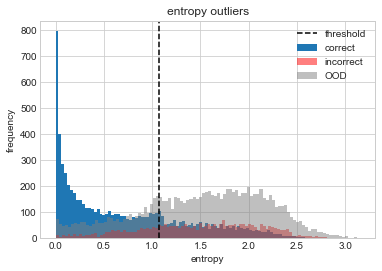

['exit_1']
entropy  lr_auc 0.18217208399091403 Best Threshold=3.245720863342285, G-Mean=0.7491508683804754, TPR=0.7891953154514545, FPR=0.28886168910648713


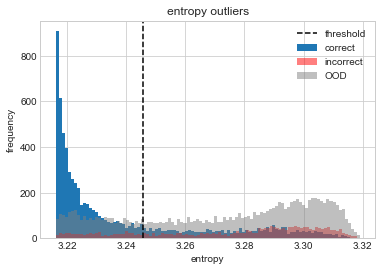

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7009  1.070848         5840          2591              5059           0.692682             0.600047
1  Main_exit       4160        7409         0.7353        NA         4160          7409              2268           0.359582             0.196041


In [70]:
#BSD adam
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.19351667977728781 Best Threshold=3.2695937156677246, G-Mean=0.73100920993064, TPR=0.7325309261116684, FPR=0.270509345127693


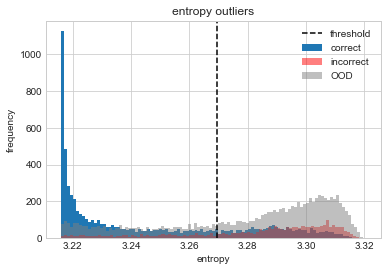

['exit_1']
entropy  lr_auc 0.18146035706859165 Best Threshold=3.225433111190796, G-Mean=0.7501196516015248, TPR=0.784570596797671, FPR=0.2828185328185328


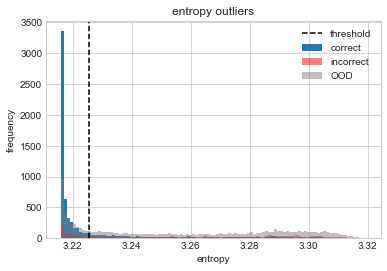

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7009  3.269594         5914          3157              5113           0.651968             0.563664
1  Main_exit       4086        6843         0.7252        NA         4086          6843              2193           0.373868             0.200659


In [16]:
#branchy adam
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.16942989792534446 Best Threshold=3.255749225616455, G-Mean=0.7563291480712097, TPR=0.8045930701047542, FPR=0.28903963820164935


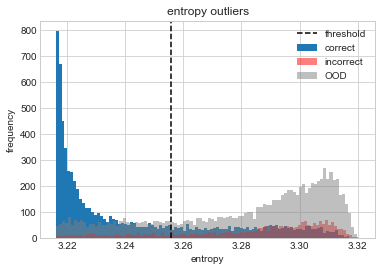

['exit_1']
entropy  lr_auc 0.22186869273505777 Best Threshold=1.270514726638794, G-Mean=0.7053121092531525, TPR=0.7946805060006488, FPR=0.3740060719965303


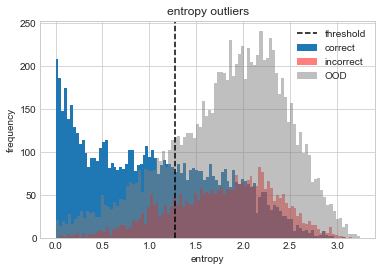

['exit_1', 'exit_2']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1      10000       10000         0.7518   3.255749         5831          2286              5345           0.718369             0.658495
1    exit_2       4169        7714         0.6917   1.270515          792           968               462           0.450000             0.262500


In [41]:
#BSD SGD_0.001
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=False,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.2226987774406568 Best Threshold=1.4505038261413574, G-Mean=0.7055884800175847, TPR=0.7488399071925754, FPR=0.33516483516483514


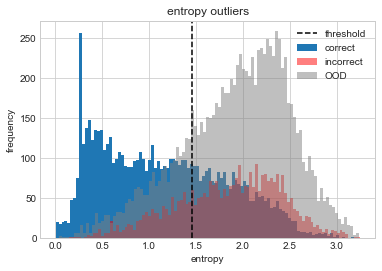

['exit_1']
entropy  lr_auc 0.17277704220056916 Best Threshold=3.2647457122802734, G-Mean=0.7575472593963388, TPR=0.7702808112324493, FPR=0.2549757934373319


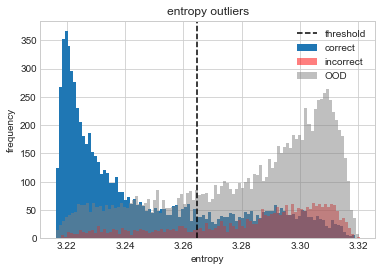

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6552  1.450504         5223          2127              4356           0.710612             0.592653
1  Main_exit       4777        7873         0.7436        NA         4777          7873              2890           0.377628             0.228458


In [49]:
#BSD adam_0.001
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.22186869273505777 Best Threshold=1.270514726638794, G-Mean=0.7053121092531525, TPR=0.7946805060006488, FPR=0.3740060719965303


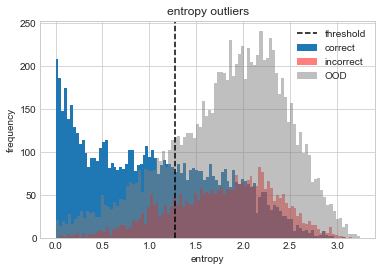

['exit_1']
entropy  lr_auc 0.16942989792534446 Best Threshold=3.255749225616455, G-Mean=0.7563291480712097, TPR=0.8045930701047542, FPR=0.28903963820164935


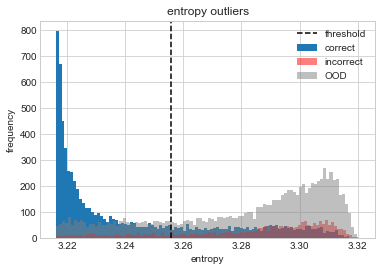

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6917  1.270515         4964          2004              4330           0.712400             0.621412
1  Main_exit       5036        7996         0.7518        NA         5036          7996              3082           0.386433             0.236495


In [42]:
#Baseline
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.1856927140476821 Best Threshold=3.267930746078491, G-Mean=0.7442406806629371, TPR=0.7676553672316384, FPR=0.27845982142857145


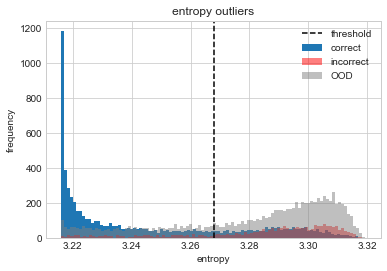

['exit_1']
entropy  lr_auc 0.1836042635315361 Best Threshold=3.223947525024414, G-Mean=0.745469835272858, TPR=0.7910284463894968, FPR=0.2974648663543676


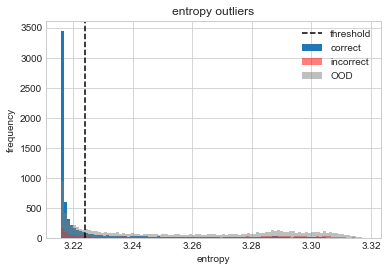

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7168  3.267931         5831          2967              5172           0.662764             0.587861
1  Main_exit       4169        7033         0.7258        NA         4169          7033              2193           0.372166             0.195769


In [48]:
#Branching
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.19417674560679388 Best Threshold=3.2819738388061523, G-Mean=0.7352470393732573, TPR=0.7308752584424535, FPR=0.2603550295857988


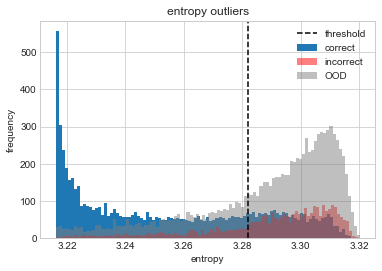

['exit_1']
entropy  lr_auc 0.18069844119215955 Best Threshold=3.2315311431884766, G-Mean=0.7490215787971545, TPR=0.7881387541961955, FPR=0.2881541194152207


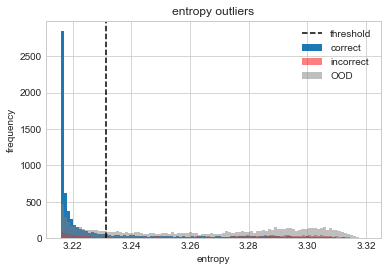

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7098  3.281974         6033          3065              5251           0.663113              0.57716
1  Main_exit       3967        6935         0.7319        NA         3967          6935              2120           0.363878              0.19446


In [43]:
#BSD
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.1341651753210079 Best Threshold=0.21491119265556335, G-Mean=0.7950990161256442, TPR=0.8664804469273742, FPR=0.27040194884287455


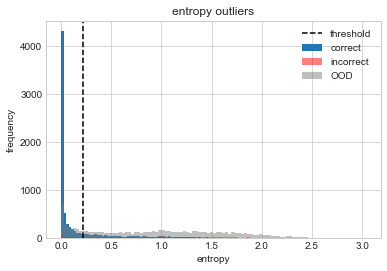

['exit_1']
entropy  lr_auc 0.12005006251371846 Best Threshold=0.02590709738433361, G-Mean=0.8114755626009562, TPR=0.8465473145780051, FPR=0.22214319582740635


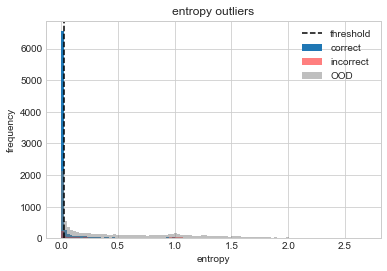

['exit_1', 'exit_2']
entropy  lr_auc 0.11912484109824943 Best Threshold=3.2332911491394043, G-Mean=0.8117346404128742, TPR=0.8481532147742818, FPR=0.2231201686577653


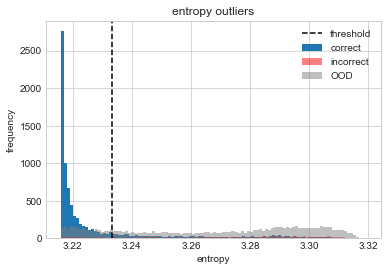

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.8210  0.214911         6230          1978              5990           0.759016             0.729776
1     exit_2       3770        8022         0.8436  0.025907         1211          1045              1063           0.536791             0.471188
2  Main_exit       2559        6977         0.8538        NA         2559          6977              1487           0.268352             0.155935


In [78]:
#BSD
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
entropy  lr_auc 0.19112388096335958 Best Threshold=3.2666544914245605, G-Mean=0.7396169014893824, TPR=0.7990196078431373, FPR=0.31536954087346025


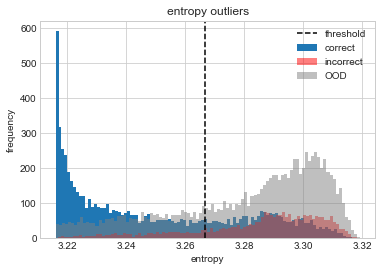

['exit_1']
entropy  lr_auc 0.1334109764324505 Best Threshold=3.216427803039551, G-Mean=0.7954076481384014, TPR=0.8541912632821723, FPR=0.2593306043823742


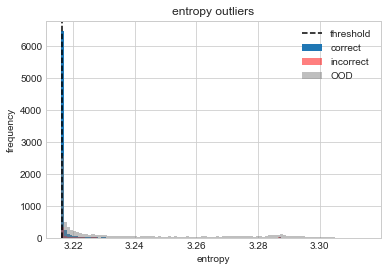

['exit_1', 'exit_2']
entropy  lr_auc 0.13560830596228823 Best Threshold=3.2167882919311523, G-Mean=0.793373837085172, TPR=0.8656898656898657, FPR=0.27290121980387466


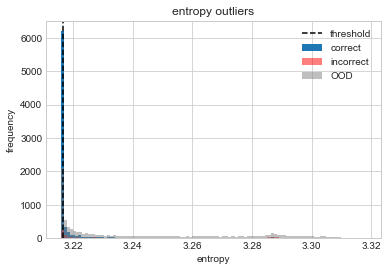

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7144  3.266654         5466          2814              4891           0.660145             0.590700
1     exit_2       4534        7186         0.8306  3.216428         2089          1216              1931           0.632073             0.584266
2  Main_exit       2445        5970         0.8362        NA         2445          5970              1429           0.290553             0.169816


In [69]:
#CE Early stopping, Calibration
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildCompareDistribPlot(output_ID,output_OOD,metrics=["entropy"], threshold="gmean",  legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])
